In [113]:
from firedrake import *
import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [114]:
mesh = UnitSquareMesh(40, 40, quadrilateral=True)

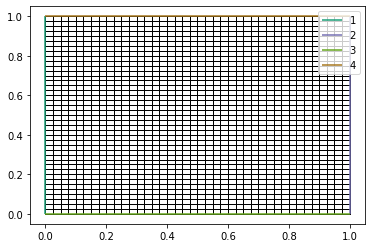

In [115]:
fig, axes = plt.subplots()
triplot(mesh, axes=axes)
axes.legend();

In [116]:
V = FunctionSpace(mesh, "DQ", 1)
W = VectorFunctionSpace(mesh, "CG", 1)

In [117]:
x, y = SpatialCoordinate(mesh)

velocity = as_vector((4 - 4 * y, 3 * x - 4))
u = Function(W).interpolate(velocity)


In [118]:
bell_r0 = 0.15; bell_x0 = 0.25; bell_y0 = 0.5
cone_r0 = 0.15; cone_x0 = 0.5; cone_y0 = 0.25
cyl_r0 = 0.15; cyl_x0 = 0.5; cyl_y0 = 0.75
slot_left = 0.475; slot_right = 0.525; slot_top = 0.85

bell = 0.25*(1+cos(math.pi*min_value(sqrt(pow(x-bell_x0, 2) + pow(y-bell_y0, 2))/bell_r0, 1.0)))
cone = 1.0 - min_value(sqrt(pow(x-cone_x0, 2) + pow(y-cone_y0, 2))/cyl_r0, 1.0)
slot_cyl = conditional(sqrt(pow(x-cyl_x0, 2) + pow(y-cyl_y0, 2)) < cyl_r0,
             conditional(And(And(x > slot_left, x < slot_right), y < slot_top),
               0.0, 1.0), 0.0)

In [119]:
q = Function(V).interpolate(1.0 + bell + cone + slot_cyl)
q_init = Function(V).assign(q)

In [120]:
qs = []

In [121]:
T = 2*math.pi
dt = T/1200
dtc = Constant(dt)
q_in = Constant(1.0)

In [122]:
dq_trial = TrialFunction(V)
phi = TestFunction(V)
a = phi*dq_trial*dx

In [123]:
n = FacetNormal(mesh)
un = 0.5*(dot(u, n) + abs(dot(u, n)))

In [124]:
L1 = dtc*(q*div(phi*u)*dx
          - conditional(dot(u, n) < 0, phi*dot(u, n)*q_in, 0.0)*ds
          - conditional(dot(u, n) > 0, phi*dot(u, n)*q, 0.0)*ds
          - (phi('+') - phi('-'))*(un('+')*q('+') - un('-')*q('-'))*dS)

In [125]:
q1 = Function(V); q2 = Function(V)
L2 = replace(L1, {q: q1}); L3 = replace(L1, {q: q2})

In [126]:
dq = Function(V)

In [127]:
params = {'ksp_type': 'preonly', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}
prob1 = LinearVariationalProblem(a, L1, dq)
solv1 = LinearVariationalSolver(prob1, solver_parameters=params)
prob2 = LinearVariationalProblem(a, L2, dq)
solv2 = LinearVariationalSolver(prob2, solver_parameters=params)
prob3 = LinearVariationalProblem(a, L3, dq)
solv3 = LinearVariationalSolver(prob3, solver_parameters=params)

In [128]:
limiter = VertexBasedLimiter(V)

In [129]:
t = 0.0
step = 0
output_freq = 20

In [130]:
limiter.apply(q)

In [131]:
if step % output_freq == 0:
        qs.append(q.copy(deepcopy=True))
        print("t=", t)
while t < T - 0.5*dt:
    solv1.solve()
    q1.assign(q + dq)
    limiter.apply(q1)

    solv2.solve()
    q2.assign(0.75*q + 0.25*(q1 + dq))
    limiter.apply(q2)

    solv3.solve()
    q.assign((1.0/3.0)*q + (2.0/3.0)*(q2 + dq))

    step += 1
    t += dt

    if step % output_freq == 0:
        qs.append(q.copy(deepcopy=True))
        print("t=", t)

t= 0.0
t= 0.10471975511965971
t= 0.2094395102393196
t= 0.3141592653589795
t= 0.4188790204786394
t= 0.5235987755982993
t= 0.6283185307179592
t= 0.7330382858376191
t= 0.837758040957279
t= 0.9424777960769389
t= 1.0471975511965979
t= 1.1519173063162556
t= 1.2566370614359132
t= 1.361356816555571
t= 1.4660765716752286
t= 1.5707963267948863
t= 1.675516081914544
t= 1.7802358370342017
t= 1.8849555921538594
t= 1.9896753472735171
t= 2.094395102393179
t= 2.199114857512841
t= 2.303834612632503
t= 2.4085543677521652
t= 2.5132741228718274
t= 2.6179938779914895
t= 2.7227136331111517
t= 2.827433388230814
t= 2.932153143350476
t= 3.036872898470138
t= 3.1415926535898
t= 3.2463124087094624
t= 3.3510321638291245
t= 3.4557519189487866
t= 3.5604716740684488
t= 3.665191429188111
t= 3.769911184307773
t= 3.874630939427435
t= 3.9793506945470973
t= 4.084070449666752
t= 4.188790204786406
t= 4.293509959906059
t= 4.398229715025712
t= 4.502949470145365
t= 4.607669225265019
t= 4.712388980384672
t= 4.817108735504325
t= 

In [132]:
L2_err = sqrt(assemble((q - q_init)*(q - q_init)*dx))
L2_init = sqrt(assemble(q_init*q_init*dx))
print(L2_err/L2_init)

0.24087898041074562


In [133]:
nsp = 16
fn_plotter = FunctionPlotter(mesh, num_sample_points=nsp)

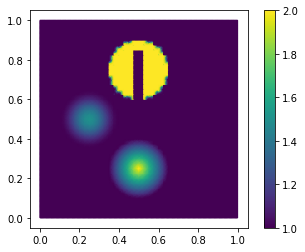

In [134]:
fig, axes = plt.subplots()
axes.set_aspect('equal')
colors = tripcolor(q_init, num_sample_points=nsp, vmin=1, vmax=2, axes=axes)
fig.colorbar(colors)

In [135]:
def animate(q):
    colors.set_array(fn_plotter(q))

In [136]:
interval = 1e3 * output_freq * dt
animation = FuncAnimation(fig, animate, frames=qs, interval=interval)
try:
    animation.save("DG_advection_limiter_try8.mp4", writer="ffmpeg")
except:
    print("Failed to write movie! Try installing `ffmpeg`.")